In [1]:
! pip3 install torch torchvision torchaudio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/representation_learning')
!ls

In [4]:
import torch
import numpy as np
import random

def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# random seed
setup_seed(7)

In [5]:

import numpy as np
import sklearn
import scipy.stats as stats
from scipy.stats import norm 
from scipy.stats import multivariate_normal as mvn
from sympy.matrices import Matrix,GramSchmidt
import torch

X = norm.rvs(size=(50,1000)) #(50, 1000) <class 'numpy.ndarray'>
beta = norm.rvs(size=(50,5))  #(50, 5) <class 'numpy.ndarray'>

MA = [Matrix(col) for col in beta.T]
# Schmidt orthogonalization, standardization
beta_ON = GramSchmidt(MA, True)
beta_ON = np.array([np.array(i) for i in beta_ON]).squeeze().astype(float).T #(50, 5) <class 'numpy.ndarray'>
alpha = 8 * np.sqrt(50) * np.max(X)
f = 500


X_ = torch.tensor(X.T, dtype=torch.float)

In [6]:
Y = np.sin( 2 * np.pi /alpha * f*np.matmul(beta_ON.T, X)) #(5, 1000) <class 'numpy.ndarray'>

Y_ = torch.tensor(Y.T, dtype=torch.float)

Text(0, 0.5, 'Y')

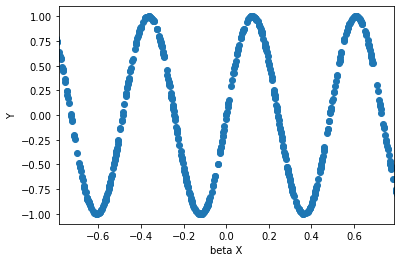

In [7]:
import matplotlib.pyplot as plt

plt.scatter((beta_ON.T@X).T[:,1], Y.T[:,1])
plt.xlim((-np.pi/4, np.pi/4))
#plt.ylim((-np.pi/4, np.pi/4))
plt.xlabel('beta X')
plt.ylabel('Y')

In [8]:
device = torch.device(("cuda:0" if torch.cuda.is_available() else "cpu"))
print(device)

X_ = X_.to(device)
Y_ = Y_.to(device)

cpu


# 1. Generator architechture

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from MonotonicNN import MonotonicNN


class Transformer(nn.Module):  

    def __init__(self, input_dim: int=50, output_dim: int=5):
        super(Transformer, self).__init__()
        
        self.dense = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
          
            nn.Linear(64, output_dim)   
        )
        
        #self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        ksi = self.dense(x)
        return ksi
    
    
class Mapping(nn.Module):
    def __init__(self, input_dim: int=50, output_dim: int=5):
        super(Mapping, self).__init__()
        self.output_dim = output_dim
        self.trans = Transformer(input_dim, output_dim)
        
        keys = np.arange(1, self.output_dim+1)  #[ 1  2  3 ... 49 50]
        keys = [str(i) for i in keys]
        keys = tuple(keys)
        self.dic = dict.fromkeys(keys, MonotonicNN(3, [50, 50], nb_steps=100, dev=device))
        for attr, value in self.dic.items():
            setattr(self, attr, value)
            
    def forward(self, x):
        count = 0
        for attr, _ in self.dic.items():
            
            ksi = self.trans(x)
            #ksi = x
            u_i = getattr(self, attr)(torch.unsqueeze(ksi[:,count], 1), torch.ones(ksi.shape[0], 2).to(device))
            u_i = (u_i - torch.min(u_i)) / (torch.max(u_i) - torch.min(u_i)) #min_max_scaling
            
            if count==0:
                u = u_i
            else:
                u = torch.cat((u, u_i), dim=1)
            count = count+1
            
        return ksi, u
    

class Generator(nn.Module):
    def __init__(self, input_dim1: int=50, input_dim2: int=5,
                        output_dim1: int=50, output_dim2: int=5):
        super(Generator, self).__init__()
        self.model1 = Mapping(input_dim1, output_dim1)
        self.model2 = Mapping(input_dim2, output_dim2)
        
    def forward(self, x1, x2):
        ksi, u1 = self.model1(x1)
        eta, u2 = self.model2(x2)
        return ksi, eta, u1, u2

In [10]:
def dc_loss(ksi, eta, batch_size):
  with torch.autograd.set_detect_anomaly(True):
    #calculate formular from： Xiaoming Huo & Gábor J. Székely (2016) Fast Computing for Distance Covariance, 
    #              Technometrics, 58:4, 435-447, DOI: 10.1080/00401706.2015.1054435

    ## distance matrix of ksi (named A) and eta (named B)
    m1 = torch.ones((batch_size, batch_size)).to(device)*torch.sum(torch.mul(ksi,ksi), 1).view(-1,1)
    m2 = torch.ones((batch_size, batch_size)).to(device)*torch.sum(torch.mul(eta,eta), 1).view(-1,1)  
   
    A = m1 + m1.T - 2*torch.matmul(ksi, ksi.T)
    B = m2 + m2.T - 2*torch.matmul(eta, eta.T)
    ## diagonal elements of A and B are manually zeroed, cause they may be numerically negative
    for i in range(batch_size):
        A[i,i]=0
        B[i,i]=0

    A = torch.sqrt(A)
    B = torch.sqrt(B)
    #print(A)   

    ## row sum of A(named A1) and B(named B1).and corresponding total sum A_,B_
    A1 = torch.sum(A, 1)  
    B1 = torch.sum(B, 1)  #torch.size([bitch_size])
    A_ = torch.sum(A)
    B_ = torch.sum(B)    #scalar

    ## squared distance covariance
    V12 = 1/(batch_size*(batch_size-3))* torch.sum(torch.mul(A,B)) - 2/(batch_size*(batch_size-2)*(batch_size-3))*torch.sum(torch.mul(A1,B1)) + A_*B_/(batch_size*(batch_size-1)*(batch_size-2)*(batch_size-3))
    #print(1/(batch_size*(batch_size-3))* torch.sum(torch.mul(A,B)))
    #print(2/(batch_size*(batch_size-2)*(batch_size-3))*torch.sum(torch.mul(A1,B1)))
    #print(A_*B_/(batch_size*(batch_size-1)*(batch_size-2)*(batch_size-3)))

    
    V11 = 1/(batch_size*(batch_size-3))* torch.sum(torch.mul(A,A)) - 2/(batch_size*(batch_size-2)*(batch_size-3))*torch.sum(torch.mul(A1,A1)) + A_*A_/(batch_size*(batch_size-1)*(batch_size-2)*(batch_size-3))

    V22 = 1/(batch_size*(batch_size-3))* torch.sum(torch.mul(B,B)) - 2/(batch_size*(batch_size-2)*(batch_size-3))*torch.sum(torch.mul(B1,B1)) + B_*B_/(batch_size*(batch_size-1)*(batch_size-2)*(batch_size-3))
    
    ## return squared distance correlation
    return torch.max(V12/torch.sqrt(V11*V22),torch.tensor([0]).to(device))


# 3. train

In [ ]:
import torch.utils.data as Data
import math 
from tqdm import *
import gc
from sklearn.svm import SVC
import os
from scipy.stats import pearsonr

def CCRL_loss(u1, u2, output_dim1):
    loss_duli = 0
    loss_uniform = 0
    loss_co = 0
    for j in range(output_dim1):
        A = torch.unsqueeze(u1[:, j], 1)
        B = torch.unsqueeze(u2[:, j], 1)
                
        ## independence constraint of each two components of U and V.        
        for k in range(j+1, output_dim1):
            C = torch.unsqueeze(u1[:, k], 1)
            D = torch.unsqueeze(u2[:, k], 1)
            #print(12*torch.mean(torch.mul(A, C))-3)
            loss_duli = loss_duli + torch.abs(12*torch.mean(torch.mul(A, C))-3) + torch.abs(12*torch.mean(torch.mul(B, D))-3)
                        
        ## U（0，1）constraint
        A_mean = torch.mean(A)
        A_std = torch.std(A)
        B_mean = torch.mean(B)
        B_std = torch.std(B)             
        loss_uniform = loss_uniform + ( (A_mean-0.5)**2 + (B_mean-0.5)**2 ) + ((A_std- 1/(12)**0.5)**2 + (B_std- 1/(12)**0.5)**2 )    
                
        ## L_2 distance between the joint distribution of (ui,vi) and the comonotonicity coupla
        loss_co = loss_co + torch.mean(torch.mul(A-B, A-B))
                
            
    ## total loss
    generator_loss = 4*loss_uniform +  loss_co + 1/10*loss_duli

    
    return  4*loss_uniform, 3*loss_co, 1/10*loss_duli, generator_loss
   


def train(batch_size: int=500):
    input_dim1 = 50
    input_dim2 = 5
    output_dim1 = output_dim2 = 5
    lr=0.001
    
    ## Models
    
    generator = Generator(input_dim1, input_dim2, output_dim1, output_dim2)
    generator = generator.to(device)
    '''
    generator = Generator(input_dim1, input_dim2, output_dim1, output_dim2)
    state_dic = torch.load('XRMB_2022_03_01_TD_Generator_Param.pkl',map_location=torch.device(device))
    generator.load_state_dict(state_dic['generator'])
    generator = generator.to(device)
    '''
    

    ## Optimizer
    generator_optim = torch.optim.Adam(generator.parameters(), lr=lr)
    
    ## dataloader
    torch_dataset = Data.TensorDataset(X_, Y_)
    loader = Data.DataLoader(
        dataset = torch_dataset,
        batch_size = batch_size,
        shuffle = True
    )
    
    ## list for save loss
    g_loss = list()
    v_loss = list()
    

    for epoch in tqdm(range(2000)):
      
        for i, (batch_x1, batch_x2) in tqdm(enumerate(loader)):
            
            ## 
            generator_optim.zero_grad()
            
            ## 
            ksi, eta, u1, u2 = generator(batch_x1, batch_x2)
            generator = generator.to(device)
            
            #generator_loss 
            loss_uniform,loss_co, loss_duli, generator_loss = CCRL_loss(u1, u2, output_dim1)
            
            print('loss_co:', loss_co)
            print('loss_uniform:', loss_uniform)
            print('loss_duli:',loss_duli)   
            

            total_sum = 0
            total_sum_ = 0
            for i in range(5):
                u1_ = u1.clone().cpu().detach().numpy()
                u2_ = u2.clone().cpu().detach().numpy()
                ksi_ = ksi.clone().cpu().detach().numpy()
                eta_ = eta.clone().cpu().detach().numpy()
                total_sum = total_sum + np.abs(pearsonr(u1_[:,i], u2_[:,i])[0])
                total_sum_ = total_sum_ + np.abs(pearsonr(ksi_[:,i], eta_[:,i])[0])

            print('total_sum:U,V',total_sum)
            print('total_sum:ksi,eta',total_sum_)
  
                
            generator_loss.backward()
            generator_optim.step()

            
            
            
            
            
            if i!=0 and i%1==0:
                
                
                b1 = generator_loss.cpu().clone()
                g_loss.append(b1.tolist())
        
                

                print('\n',"="*5, "epoch=", epoch+1,",","batch=", i,"="*5, 
                      "generator_loss：", b1, "="*5)
                
            gc.collect()
            torch.cuda.empty_cache()          
        
        gc.collect()
        torch.cuda.empty_cache()

    #return generator, g_loss, c_acc_L, tl_acc_L2R, c_acc_R, tl_acc_R2L
    return generator, g_loss
    
if __name__ == "__main__":
    
    #generator, g_loss, c_acc_L, tl_acc_L2R, c_acc_R, tl_acc_R2L= train(1000)
     generator, g_loss = train(500)

4. plot loss

(4000, 1)
<class 'numpy.ndarray'>


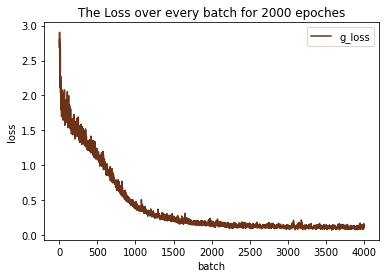

In [ ]:
# plot loss
import matplotlib.pyplot as plt
import numpy as np


g_loss = np.array(g_loss).reshape((-1,1)) #
print(g_loss.shape)
print(type(g_loss))

x = np.arange(1, g_loss.shape[0]+1)
plt.plot(x, g_loss, '#6B331A', label='g_loss')

plt.title('The Loss over every batch for 2000 epoches')
plt.xlabel('batch')
plt.ylabel('loss')

plt.legend() 
#plt.show()

# 5 results

In [ ]:
## save model
#torch.save({'generator': generator.state_dict()}, 'simulated_f=50_generator_param(2000，64-64).pkl')

In [14]:
## load model

generator = Generator(50,5,5,5)
state_dic = torch.load('simulated_f=500_generator_param(2000，64-64).pkl',map_location=torch.device(device))
generator.load_state_dict(state_dic['generator'])
generator = generator.to(device)

In [15]:
ksi, eta, u1, u2 = generator(X_, Y_)

u1_ = u1.clone().cpu().detach().numpy()
u2_ = u2.clone().cpu().detach().numpy()
ksi_ = ksi.clone().cpu().detach().numpy()
eta_ = eta.clone().cpu().detach().numpy()

In [16]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

total_sum=0
total_sum_=0
total_sum1=0
total_sum1_=0
for i in range(5):
    total_sum_ = total_sum_ + np.abs(pearsonr(ksi_[:,i], eta_[:,i])[0])
    total_sum = total_sum + np.abs(pearsonr(u1_[:,i], u2_[:,i])[0])
    total_sum1_ = total_sum1_ + np.abs(spearmanr(ksi_[:,i], eta_[:,i])[0])
    total_sum1 = total_sum1 + np.abs(spearmanr(u1_[:,i], u2_[:,i])[0])

print('total absolute sum of Pearson --- ksi,eta : ',total_sum_)
print('total absolute sum of Pearson --- U,V : ',total_sum)
print('total absolute sum of Spearman --- ksi,eta : ',total_sum1_)
print('total absolute sum of Spearman --- U,V : ',total_sum1)
print('unbiased squared distance correlation ---ksi,eta :', dc_loss(ksi, eta, 1000).detach().cpu())
print('unbiased squared distance correlation ---U,V :', dc_loss(u1, u2, 1000).detach().cpu())

total absolute sum of Pearson --- ksi,eta :  4.872747788216773
total absolute sum of Pearson --- U,V :  4.964682855637945
total absolute sum of Spearman --- ksi,eta :  4.964971637954335
total absolute sum of Spearman --- U,V :  4.964971637954335
unbiased squared distance correlation ---ksi,eta : tensor([0.9783])
unbiased squared distance correlation ---U,V : tensor([0.9888])


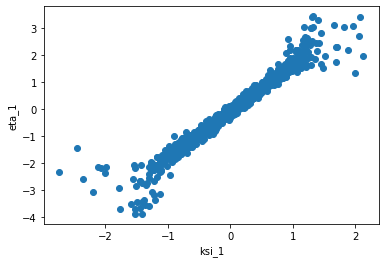

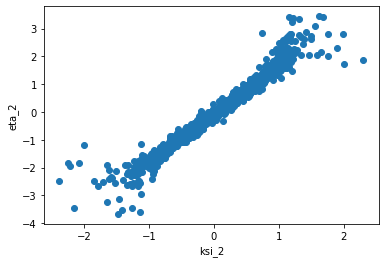

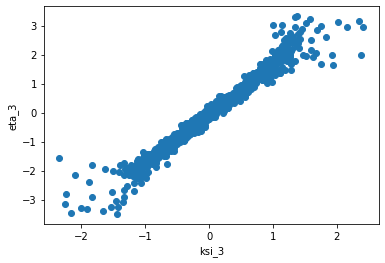

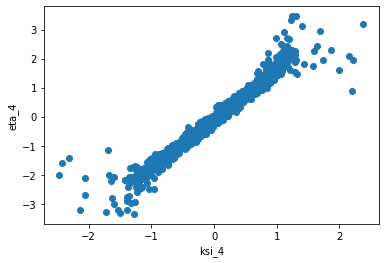

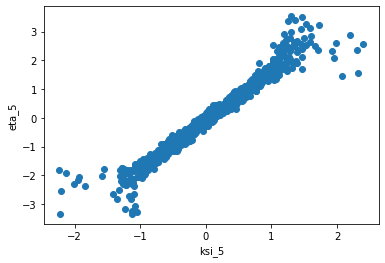

In [ ]:
import matplotlib.pyplot as plt

#fig, ax = plt.subplots(3,2, figsize=(10,5))

for i in range(5):
    plt.figure()
    plt.scatter(ksi_[:,i], eta_[:,i])
    a = 'ksi_'+ repr(i+1)
    b = 'eta_'+ repr(i+1)
    plt.xlabel(a)
    plt.ylabel(b)
    plt.show()


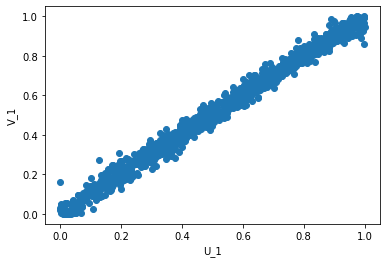

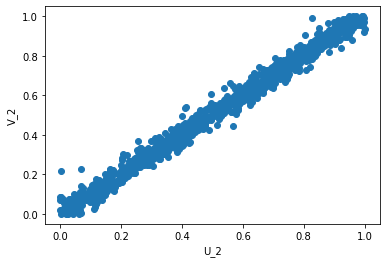

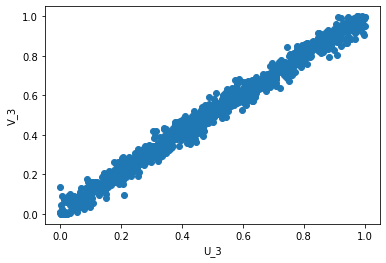

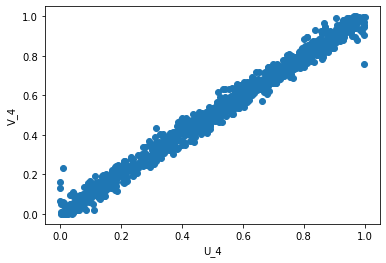

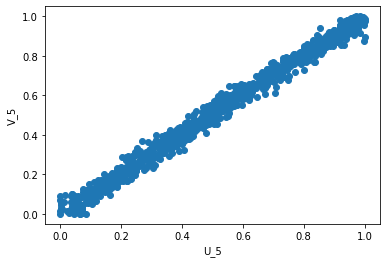

In [ ]:
import matplotlib.pyplot as plt

#fig, ax = plt.subplots(3,2, figsize=(10,5))

for i in range(5):
    plt.figure()
    plt.scatter(u1_[:,i], u2_[:,i])
    a = 'U_'+ repr(i+1)
    b = 'V_'+ repr(i+1)
    plt.xlabel(a)
    plt.ylabel(b)
    plt.show()

In [ ]:
import pandas as pd

u1_ = pd.DataFrame(u1_, columns=['1','2','3','4','5'])
u2_ = pd.DataFrame(u2_, columns=['1','2','3','4','5'])
ksi_ = pd.DataFrame(ksi_, columns=['1','2','3','4','5'])
eta_ = pd.DataFrame(eta_, columns=['1','2','3','4','5'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d95b8d4d0>,
      dtype=object)

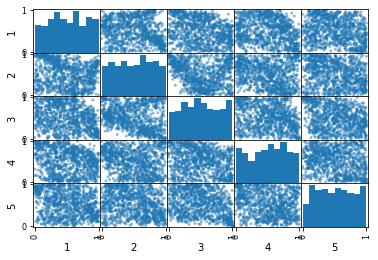

In [ ]:
pd.plotting.scatter_matrix(u1_)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d959aab90>,
      dtype=object)

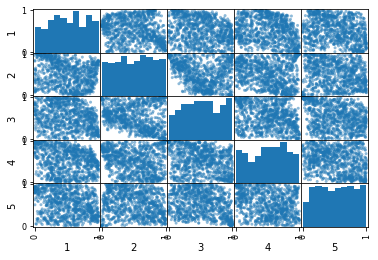

In [ ]:
pd.plotting.scatter_matrix(u2_)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d93a37490>,
      dtype=object)

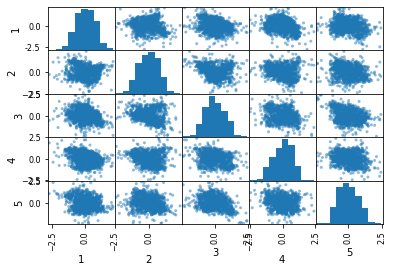

In [ ]:
pd.plotting.scatter_matrix(ksi_)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d930f6790>,
      dtype=object)

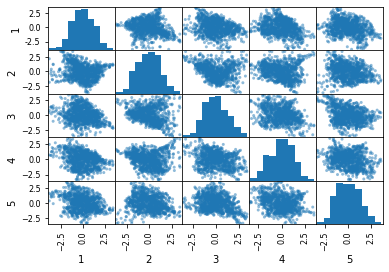

In [ ]:
pd.plotting.scatter_matrix(eta_)